In [1]:
# using examples/cosmicshear to check theory data vectors from firecrown (binning etc)
# accessing firecrown stuff from likelihood object is from the firecrown des3x2/..PT example

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sacc
import pyccl as ccl

In [4]:
import firecrown.likelihood.gauss_family.statistic.source.weak_lensing as wl
import firecrown.likelihood.gauss_family.statistic.source.number_counts as nc
from firecrown.likelihood.gauss_family.statistic.two_point import TwoPoint
from firecrown.likelihood.gauss_family.gaussian import ConstGaussian
from firecrown.modeling_tools import ModelingTools
from firecrown.parameters import ParamsMap

In [5]:
h=0.6727
cosmo_fid_srd = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

cosmo_fid_srd.compute_nonlin_power()

In [6]:
systematics_params = ParamsMap(
        {
            "lens0_bias": 1.562362,
            "lens1_bias": 1.732963,
            "lens2_bias": 1.913252,
            "lens3_bias": 2.100644,
            "lens4_bias": 2.293210,
        }
    )

In [7]:
def build_likelihood(_):
    """Create a firecrown likelihood for an SRD-like galaxy clustering analysis.
    No systematics yet apart from linear bias. 
    Based on DES 3x2pt example in firecrown"""
    
    sources: Dict[str, nc.NumberCounts] = {}
        
    for i in range(5):
        sources[f"lens{i}"] = nc.NumberCounts(
            sacc_tracer=f"lens{i}"
        )

    # Now that we have all sources we can instantiate all the two-point
    # functions. For each one we create a new two-point function object.
    stats = {}
    for i in range(5):
        stats[f"ell_cl_lens{i}_lens{i}"] = TwoPoint(
            source0=sources[f"lens{i}"],
            source1=sources[f"lens{i}"],
            sacc_data_type="galaxy_density_cl",
        )

    # Here we instantiate the actual likelihood. The statistics argument carry
    # the order of the data/theory vector.
    modeling_tools = ModelingTools()
    likelihood = ConstGaussian(statistics=list(stats.values()))

    # We load the correct SACC file.
    saccfile = "lsst_y1_desc_srd_sacc.fits"
    sacc_data = sacc.Sacc.load_fits(saccfile)

    likelihood.read(sacc_data)
    
    print(
        "Using parameters:", list(likelihood.required_parameters().get_params_names())
    )

    # This script will be loaded by the appropriated connector. The framework
    # will call the factory function that should return a Likelihood instance.
    return likelihood, modeling_tools


Text(0.5, 1.0, 'redshift distribution for 5 redshift bins (LSST Y1)')

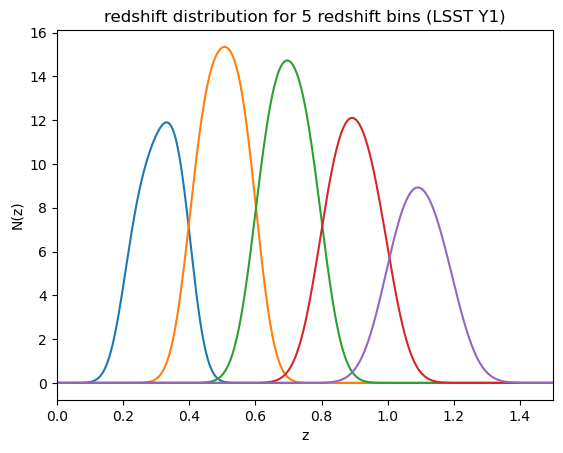

In [8]:
# Load sacc file
saccfile = "lsst_y1_desc_srd_sacc.fits"
sacc_data = sacc.Sacc.load_fits(saccfile)

for i in range(5):
    lens_tracer = sacc_data.get_tracer("lens%d"%i)
    lens_z, lens_nz = lens_tracer.z, lens_tracer.nz
    plt.plot(lens_z, lens_nz, label='bin %d'%(i+1))
plt.xlabel('z')
plt.ylabel('N(z)')
plt.xlim(0, 1.5)
#plt.legend()
plt.title('redshift distribution for 5 redshift bins (LSST Y1)')

In [9]:
for n, t in sacc_data.tracers.items():
    print(t.name, t.quantity, type(t))
    
# Type of power spectra
data_types = np.unique([d.data_type for d in sacc_data.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", sacc_data.get_tracer_combinations())

# Data size
print("Size: ", sacc_data.mean.size)

lens0 galaxy_density <class 'sacc.tracers.NZTracer'>
lens1 galaxy_density <class 'sacc.tracers.NZTracer'>
lens2 galaxy_density <class 'sacc.tracers.NZTracer'>
lens3 galaxy_density <class 'sacc.tracers.NZTracer'>
lens4 galaxy_density <class 'sacc.tracers.NZTracer'>
Data types:  ['galaxy_density_cl']
Tracer combinations:  [('lens0', 'lens0'), ('lens1', 'lens1'), ('lens2', 'lens2'), ('lens3', 'lens3'), ('lens4', 'lens4')]
Size:  100


In [10]:
for t in sacc_data.tracers:
    print(t)

lens0
lens1
lens2
lens3
lens4


In [11]:
likelihood, tools = build_likelihood(None)

# Apply the systematics parameters
likelihood.update(systematics_params)

# Prepare the cosmology object
tools.prepare(cosmo_fid_srd)

# Compute the log-likelihood, using the ccl.Cosmology object as the input
log_like = likelihood.compute_loglike(tools)

print(f"Log-like = {log_like:.1f}")

Using parameters: ['lens0_bias', 'lens1_bias', 'lens2_bias', 'lens3_bias', 'lens4_bias']
Log-like = -0.0


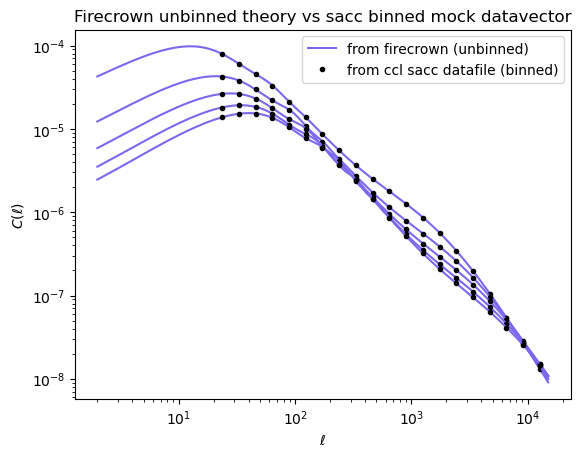

In [13]:
for i in range(len(likelihood.statistics)):
    #print(list(likelihood.statistics[i].cells.keys()))
    ells_fc = likelihood.statistics[i].ells
    c_ells_gg_fc = likelihood.statistics[i].cells[("galaxies", "galaxies")]
    l_sacc, cl_gg_sacc= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)
    
    if i==0:
        plt.loglog(ells_fc, c_ells_gg_fc, color='mediumslateblue', label='from firecrown (unbinned)')
        plt.loglog(l_sacc, cl_gg_sacc, '.', color='black', label='from ccl sacc datafile (binned)')
    else:
        plt.loglog(ells_fc, c_ells_gg_fc, color='mediumslateblue')
        plt.loglog(l_sacc, cl_gg_sacc, '.', color='black')
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.legend()
plt.title('Firecrown unbinned theory vs sacc binned mock datavector')
plt.show()

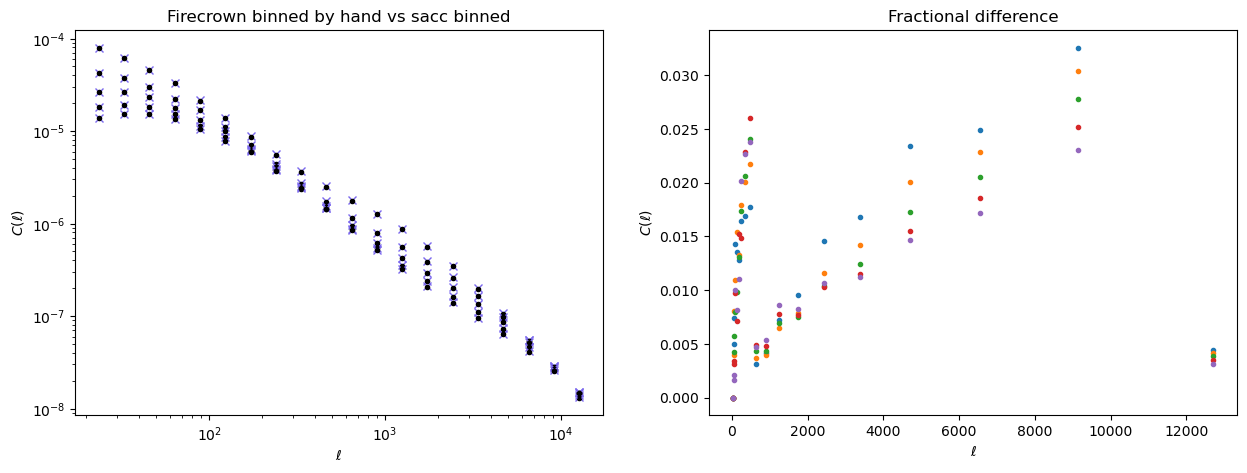

In [14]:
# bin myself using tophat window function
nbin_ell = 20 
lmin = 20
lmax = 15000
ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i in range(len(likelihood.statistics)):
    ells_fc = likelihood.statistics[i].ells
    c_ells_gg_fc = likelihood.statistics[i].cells[("galaxies", "galaxies")]
    l_sacc, cl_gg_sacc= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)

    cl_binned=[np.mean(c_ells_gg_fc[(ells_fc>=ell_edges[j]) & (ells_fc<=ell_edges[j+1])]) for j in range(nbin_ell)]
    ax1.loglog(ell_centers, cl_binned, 'x', color='mediumslateblue')
    ax1.loglog(l_sacc, cl_gg_sacc, '.', color='black')
    ax2.plot(ell_centers, (cl_binned-cl_gg_sacc)/cl_gg_sacc, '.')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C(\ell)$')
ax1.set_title('Firecrown binned by hand vs sacc binned')

ax2.set_xlabel(r'$\ell$')
ax2.set_ylabel(r'$C(\ell)$')
ax2.set_title('Fractional difference')
plt.show()  

In [15]:
# compare cosmolike
clike_dir = '/Users/heatherp/Documents/DESC/CosmoLike-DESC_SRD-master/'
lss_y1_cosmolike = np.loadtxt(clike_dir+'datav/pos_pos_Y1_fid')
lss_y1_ell = np.loadtxt(clike_dir+'ell-values')

(100,)


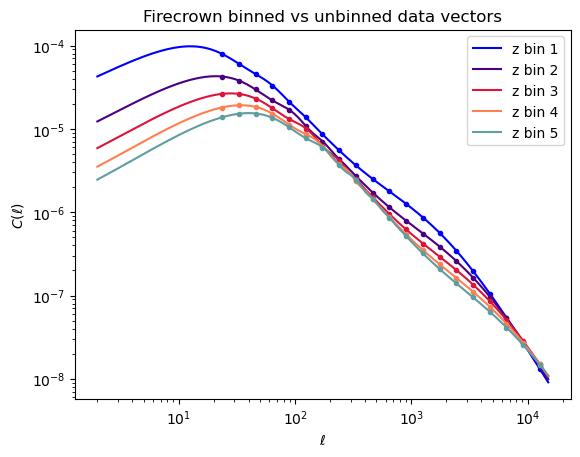

/var/folders/51/wh4httv54kl_2107dbdnknz40000gq/T/ipykernel_74111/124025167.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(ell_centers, (cl_th_fc[i*nbinl:(i+1)*nbinl]-lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1])/lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1], '*', color=colors[i], label='z bin %d'%(i+1))


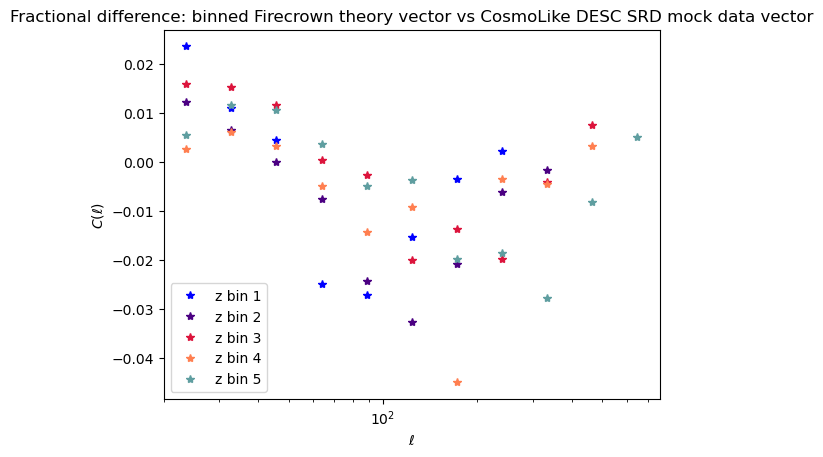

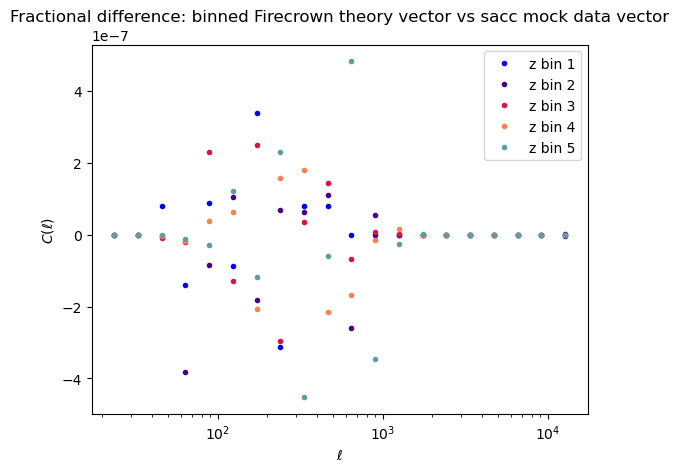

In [18]:
cl_th_fc = likelihood.compute_theory_vector(tools)
print(cl_th_fc.shape)
nbinz=5
nbinl=20
colors=['blue', 'indigo', 'crimson', 'coral', 'cadetblue']
for i in range(nbinz):
    # firecrown likelihood's unbinned data vector
    ells_fc = likelihood.statistics[i].ells
    c_ells_gg_fc = likelihood.statistics[i].cells[("galaxies", "galaxies")]

    plt.loglog(ell_centers, cl_th_fc[i*nbinl:(i+1)*nbinl], '.', color=colors[i])
    plt.loglog(ells_fc, c_ells_gg_fc, label='z bin %d'%(i+1), color=colors[i])
plt.legend()
plt.title("Firecrown binned vs unbinned data vectors")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.savefig('ell_binning_firecrown.png')
plt.show()

for i in range(nbinz):
    plt.plot(ell_centers, (cl_th_fc[i*nbinl:(i+1)*nbinl]-lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1])/lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1], '*', color=colors[i], label='z bin %d'%(i+1))
plt.legend()
plt.xscale('log')
plt.title("Fractional difference: binned Firecrown theory vector vs CosmoLike DESC SRD mock data vector")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()

for i in range(nbinz):
    l_sacc, cl_gg_sacc= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)
    plt.plot(ell_centers, (cl_th_fc[i*nbinl:(i+1)*nbinl]-cl_gg_sacc)/cl_gg_sacc, '.', color=colors[i], label='z bin %d'%(i+1)) 
plt.legend()
plt.xscale('log')
plt.title("Fractional difference: binned Firecrown theory vector vs sacc mock data vector")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()